In [2]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import minimize
from functools import lru_cache
from numpy.linalg import inv
from IPython.display import display, Math
from scipy.optimize import approx_fprime
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression
import time
import os
from scipy.stats import gamma
from scipy.special import erf, gammaincinv
from IPython.display import Markdown, display


In [3]:
start_time = time.time()

# Load Pantheon+ light curve data
pantheon_data = pd.read_csv("lcparam_full_long_zhel-pp.txt", delim_whitespace=True, comment='#')

# Load and reshape the covariance matrix
with open("sys_full_long-pp.txt", "r") as f:
    lines = f.readlines()

N = int(lines[0].strip())  # Size of the matrix
flat_data = np.array([float(x.strip()) for x in lines[1:]])
C_full = flat_data.reshape((N, N))
C_inv = np.linalg.inv(C_full)  # Invert the full covariance matrix
# Load Hubble Diagram Redshift from PANTHEON
z = pantheon_data['zHD'].values
# Define SNe with Cepheid host
is_calibrator = pantheon_data['IS_CALIBRATOR'].values.astype(int)
# Load the corrected apparent magnitudes and distance moduli from Cepheid hosts
mB = pantheon_data['m_b_corr'].values
mu_Ceph = pantheon_data['CEPH_DIST'].values
# Speed of light in km/s
c_km_s = 299792.458 

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")

/var/tmp/stamou/ipykernel_1638006/911792637.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pantheon_data = pd.read_csv("lcparam_full_long_zhel-pp.txt", delim_whitespace=True, comment='#')


⏱️ Execution time: 4.05 seconds


In [4]:
start_time=time.time()

# Load Hubble Diagram Redshift from PANTHEON
z = pantheon_data['zHD'].values
# Define SNe with Cepheid host
is_calibrator = pantheon_data['IS_CALIBRATOR'].values.astype(int)
# Load the corrected apparent magnitudes and distance moduli from Cepheid hosts
mB = pantheon_data['m_b_corr'].values
mu_Ceph = pantheon_data['CEPH_DIST'].values
# Speed of light in km/s
c_km_s = 299792.458 

# --- No-transition Hubble parameter for flat ΛCDM ---
def E_LCDM_notransition(z, Omega_m):
    return np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m))

# --- No-transition integral for luminosity distance ---

def integral_dL_notransition(z, H0, Omega_m):
    integrand = lambda zp: 1 / E_LCDM_notransition(zp, Omega_m)
    integral, _ = quad(integrand, 0, z)
    return (1 + z) * c_km_s * integral / H0

# --- No-transition theoretical distance modulus ---
def mu_theory_notransition(z_array, H0, Omega_m):
    return np.array([
        5 * np.log10(integral_dL_notransition(float(z), H0, Omega_m)) + 25
        for z in z_array
    ])

# --- No-transition chi-square function ---
def chi2_notransition(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    M, H0, Omega_m = params
    mu_model = mu_theory_notransition(z, H0, Omega_m)
    Q = np.where(
        is_calibrator == 1,
        mB - M - mu_Ceph,
        np.where(z >= 0.0, mB - M - mu_model, 0.0)
    )
    return Q.T @ C_inv @ Q

# --- Objective wrapper ---
def objective_notransition(params):
    return chi2_notransition(params, z, mB, mu_Ceph, is_calibrator, C_inv)

# --- Initial guess and bounds ---
initial_guess_notransition = [-19.3, 70.0, 0.3]
bounds_notransition = [(-20, -18), (50, 90), (0.0, 1.0)]

# --- Minimization ---
result_notransition = minimize(
    objective_notransition,
    initial_guess_notransition,
    method='Nelder-Mead',
    bounds=bounds_notransition
)

chi2_min_notransition = result_notransition.fun
M_best_notransition, H0_best_notransition, Omega_m_best_notransition = result_notransition.x

# Chi-square at minimum (from minimization result)
chi2_min_notransition = result_notransition.fun

# Number of data points
n_data = len(mB)

# Number of fitted parameters
n_params = 3  # M, H0, Omega_m

# Degrees of freedom
dof_notransition = n_data - n_params

# Reduced chi-square
red_chi2_notransition = chi2_min_notransition / dof_notransition

# Goodness-of-fit probability
from scipy.stats import chi2 as chi2_dist
fit_prob_notransition = 1 - chi2_dist.cdf(chi2_min_notransition, df=dof_notransition)

# Convert H0 to h (P&S use h, not H0)
h_best = H0_best_notransition / 100.0

# Define the 3x3x3 grid (as in P&S)
M_vals  = np.array([M_best_notransition - 0.02, M_best_notransition, M_best_notransition + 0.02])
Om_vals = np.array([Omega_m_best_notransition - 0.02, Omega_m_best_notransition, Omega_m_best_notransition + 0.02])
h_vals  = np.array([h_best - 0.002, h_best, h_best + 0.002])

# Evaluate chi-square on the grid
chi2_cube = []
grid_points = []

for M in M_vals:
    for Om in Om_vals:
        for h in h_vals:
            H0 = h * 100.0  # Convert back to H0 for chi2 evaluation
            chi2_val = chi2_notransition([M, H0, Om], z, mB, mu_Ceph, is_calibrator, C_inv)
            chi2_cube.append(chi2_val)
            grid_points.append([M, Om, h])

chi2_cube = np.array(chi2_cube)
grid_points = np.array(grid_points)



# Build design matrix for all quadratic terms
def build_quadratic_features(X):
    M = X[:, 0]
    Om = X[:, 1]
    h = X[:, 2]

    Φ = np.column_stack([
        M, Om, h,            # linear
        M**2, Om**2, h**2,   # squared
        M*Om, M*h, Om*h,     # cross terms
        np.ones_like(M)      # constant
    ])
    return Φ

# Construct feature matrix
Φ = build_quadratic_features(grid_points)

# Fit regression model (no intercept — included as constant term in Φ)
model = LinearRegression(fit_intercept=False)
model.fit(Φ, chi2_cube)

coeffs = model.coef_
# Extract coefficients
a1, a2, a3 = coeffs[0], coeffs[1], coeffs[2]
a4, a5, a6 = coeffs[3], coeffs[4], coeffs[5]
a7, a8, a9 = coeffs[6], coeffs[7], coeffs[8]
a0 = coeffs[9]

# Compute second derivatives → Fisher matrix
Fisher = np.zeros((3, 3))
Fisher[0, 0] = a4       # was 2*a4 before
Fisher[1, 1] = a5
Fisher[2, 2] = a6

Fisher[0, 1] = Fisher[1, 0] = 0.5 * a7
Fisher[0, 2] = Fisher[2, 0] = 0.5 * a8
Fisher[1, 2] = Fisher[2, 1] = 0.5 * a9


cov_matrix = np.linalg.inv(Fisher)
errors = np.sqrt(np.diag(cov_matrix))

from IPython.display import Markdown, display

# Format results in LaTeX using f-strings
latex_output = fr'''
<div align="center">$\Large\bf{{Fisher\ Matrix}}$</div>


\begin{{bmatrix}}
{Fisher[0,0]:.2f} & {Fisher[0,1]:.2f} & {Fisher[0,2]:.2f} \\
{Fisher[1,0]:.2f} & {Fisher[1,1]:.2f} & {Fisher[1,2]:.2f} \\
{Fisher[2,0]:.2f} & {Fisher[2,1]:.2f} & {Fisher[2,2]:.2f}
\end{{bmatrix}}


<div align="center">$\Large\bf{{Parameter\ Covariance\ Matrix}}$</div>


\begin{{bmatrix}}
{cov_matrix[0,0]:.2e} & {cov_matrix[0,1]:.2e} & {cov_matrix[0,2]:.2e} \\
{cov_matrix[1,0]:.2e} & {cov_matrix[1,1]:.2e} & {cov_matrix[1,2]:.2e} \\
{cov_matrix[2,0]:.2e} & {cov_matrix[2,1]:.2e} & {cov_matrix[2,2]:.2e}
\end{{bmatrix}}


<div align="center">$\Large\bf{{Best-fit\ Values}}$</div>


\begin{{aligned}}
M &= {M_best_notransition:.5f} \pm {errors[0]:.5f} \\
\Omega_m &= {Omega_m_best_notransition:.5f} \pm {errors[1]:.5f} \\
h &= {h_best:.5f} \pm {errors[2]:.5f}\ \text{{km/s/Mpc}}
\end{{aligned}}


<div align="center">$\Large\bf{{Fit\ Summary}}$</div>


\begin{{aligned}}
\chi^2_\text{{min}} &= {chi2_min_notransition:.2f} \\
\text{{Degrees of freedom}} &= {dof_notransition} \\
\chi^2_\nu &= {red_chi2_notransition:.2f} \\
P(\chi^2 > \chi^2_\text{{min}}) &= {fit_prob_notransition:.3f}
\end{{aligned}}

'''

display(Markdown(latex_output))


end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


<div align="center">$\Large\bf{Fisher\ Matrix}$</div>


\begin{bmatrix}
75296.15 & -24032.75 & -219317.05 \\
-24032.75 & 10817.54 & 70761.10 \\
-219317.05 & 70761.10 & 648803.28
\end{bmatrix}


<div align="center">$\Large\bf{Parameter\ Covariance\ Matrix}$</div>


\begin{bmatrix}
8.65e-04 & 3.16e-05 & 2.89e-04 \\
3.16e-05 & 3.24e-04 & -2.46e-05 \\
2.89e-04 & -2.46e-05 & 1.02e-04
\end{bmatrix}


<div align="center">$\Large\bf{Best-fit\ Values}$</div>


\begin{aligned}
M &= -19.24828 \pm 0.02942 \\
\Omega_m &= 0.33277 \pm 0.01799 \\
h &= 0.73417 \pm 0.01010\ \text{km/s/Mpc}
\end{aligned}


<div align="center">$\Large\bf{Fit\ Summary}$</div>


\begin{aligned}
\chi^2_\text{min} &= 1522.98 \\
\text{Degrees of freedom} &= 1698 \\
\chi^2_\nu &= 0.90 \\
P(\chi^2 > \chi^2_\text{min}) &= 0.999
\end{aligned}



⏱️ Execution time: 34.47 seconds


In [5]:
start_time = time.time()

# --- No-transition Hubble parameter ---
def E_LCDM_notransition_cut(z, Omega_m):
    return np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m))

# --- Luminosity distance integral ---
def integral_dL_notransition_cut(z, H0, Omega_m):
    integrand = lambda zp: 1 / E_LCDM_notransition_cut(zp, Omega_m)
    integral, _ = quad(integrand, 0, z)
    return (1 + z) * c_km_s * integral / H0

# --- Theoretical distance modulus ---
def mu_theory_notransition_cut(z_array, H0, Omega_m):
    return np.array([
        5 * np.log10(integral_dL_notransition_cut(float(z), H0, Omega_m)) + 25
        for z in z_array
    ])

# --- Chi-square with z<0.01 cut ---
def chi2_notransition_cut(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    M, H0, Omega_m = params
    mu_model = mu_theory_notransition_cut(z, H0, Omega_m)
    Q = np.where(
        is_calibrator == 1,
        mB - M - mu_Ceph,
        np.where(z < 0.01, 0.0, mB - M - mu_model)
    )
    return Q.T @ C_inv @ Q

# --- Minimization setup ---
def objective_notransition_cut(params):
    return chi2_notransition_cut(params, z, mB, mu_Ceph, is_calibrator, C_inv)

initial_guess_notransition_cut = [-19.3, 70.0, 0.3]
bounds_notransition_cut = [(-20, -18), (50, 90), (0.0, 1.0)]

result_notransition_cut = minimize(
    objective_notransition_cut,
    initial_guess_notransition_cut,
    method='Nelder-Mead',
    bounds=bounds_notransition_cut
)

chi2_min_notransition_cut = result_notransition_cut.fun
M_best_notransition_cut, H0_best_notransition_cut, Omega_m_best_notransition_cut = result_notransition_cut.x
h_best_cut = H0_best_notransition_cut / 100.0

# --- Fit summary ---
n_data = len(mB)
n_params = 3
dof_notransition_cut = n_data - n_params
red_chi2_notransition_cut = chi2_min_notransition_cut / dof_notransition_cut
fit_prob_notransition_cut = 1 - chi2_dist.cdf(chi2_min_notransition_cut, df=dof_notransition_cut)

# --- 3x3x3 grid around best-fit point ---
M_vals  = np.array([M_best_notransition_cut - 0.02, M_best_notransition_cut, M_best_notransition_cut + 0.02])
Om_vals = np.array([Omega_m_best_notransition_cut - 0.02, Omega_m_best_notransition_cut, Omega_m_best_notransition_cut + 0.02])
h_vals  = np.array([h_best_cut - 0.002, h_best_cut, h_best_cut + 0.002])

chi2_cube = []
grid_points = []

for M in M_vals:
    for Om in Om_vals:
        for h in h_vals:
            H0 = h * 100.0
            chi2_val = chi2_notransition_cut([M, H0, Om], z, mB, mu_Ceph, is_calibrator, C_inv)
            chi2_cube.append(chi2_val)
            grid_points.append([M, Om, h])

chi2_cube = np.array(chi2_cube)
grid_points = np.array(grid_points)

# --- Design matrix for quadratic fit ---
def build_quadratic_features(X):
    M = X[:, 0]
    Om = X[:, 1]
    h = X[:, 2]
    Φ = np.column_stack([
        M, Om, h,
        M**2, Om**2, h**2,
        M*Om, M*h, Om*h,
        np.ones_like(M)
    ])
    return Φ

Φ = build_quadratic_features(grid_points)

model = LinearRegression(fit_intercept=False)
model.fit(Φ, chi2_cube)
coeffs = model.coef_

a1, a2, a3 = coeffs[0], coeffs[1], coeffs[2]
a4, a5, a6 = coeffs[3], coeffs[4], coeffs[5]
a7, a8, a9 = coeffs[6], coeffs[7], coeffs[8]
a0 = coeffs[9]

Fisher = np.zeros((3, 3))
Fisher[0, 0] = a4
Fisher[1, 1] = a5
Fisher[2, 2] = a6
Fisher[0, 1] = Fisher[1, 0] = 0.5 * a7
Fisher[0, 2] = Fisher[2, 0] = 0.5 * a8
Fisher[1, 2] = Fisher[2, 1] = 0.5 * a9

cov_matrix = np.linalg.inv(Fisher)
errors = np.sqrt(np.diag(cov_matrix))

# --- Display results in LaTeX ---
from IPython.display import Markdown, display

latex_output = fr'''
<div align="center">$\Large\bf{{Fisher\ Matrix\ (z<0.01\ Cut)}}$</div>

\begin{{bmatrix}}
{Fisher[0,0]:.2f} & {Fisher[0,1]:.2f} & {Fisher[0,2]:.2f} \\
{Fisher[1,0]:.2f} & {Fisher[1,1]:.2f} & {Fisher[1,2]:.2f} \\
{Fisher[2,0]:.2f} & {Fisher[2,1]:.2f} & {Fisher[2,2]:.2f}
\end{{bmatrix}}

<div align="center">$\Large\bf{{Covariance\ Matrix}}$</div>

\begin{{bmatrix}}
{cov_matrix[0,0]:.2e} & {cov_matrix[0,1]:.2e} & {cov_matrix[0,2]:.2e} \\
{cov_matrix[1,0]:.2e} & {cov_matrix[1,1]:.2e} & {cov_matrix[1,2]:.2e} \\
{cov_matrix[2,0]:.2e} & {cov_matrix[2,1]:.2e} & {cov_matrix[2,2]:.2e}
\end{{bmatrix}}

<div align="center">$\Large\bf{{Best-fit\ Values\ (Cut)}}$</div>

\begin{{aligned}}
M &= {M_best_notransition_cut:.5f} \pm {errors[0]:.5f} \\
\Omega_m &= {Omega_m_best_notransition_cut:.5f} \pm {errors[1]:.5f} \\
h &= {h_best_cut:.5f} \pm {errors[2]:.5f}
\end{{aligned}}

<div align="center">$\Large\bf{{Fit\ Quality}}$</div>

\begin{{aligned}}
\chi^2_\text{{min}} &= {chi2_min_notransition_cut:.2f} \\
\text{{DoF}} &= {dof_notransition_cut} \\
\chi^2_\nu &= {red_chi2_notransition_cut:.2f} \\
P(\chi^2 > \chi^2_\text{{min}}) &= {fit_prob_notransition_cut:.3f}
\end{{aligned}}
'''

display(Markdown(latex_output))

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")



<div align="center">$\Large\bf{Fisher\ Matrix\ (z<0.01\ Cut)}$</div>

\begin{bmatrix}
73465.66 & -23655.79 & -213506.11 \\
-23655.79 & 10859.52 & 69544.99 \\
-213506.11 & 69544.99 & 630443.94
\end{bmatrix}

<div align="center">$\Large\bf{Covariance\ Matrix}$</div>

\begin{bmatrix}
8.65e-04 & 2.81e-05 & 2.90e-04 \\
2.81e-05 & 3.15e-04 & -2.52e-05 \\
2.90e-04 & -2.52e-05 & 1.02e-04
\end{bmatrix}

<div align="center">$\Large\bf{Best-fit\ Values\ (Cut)}$</div>

\begin{aligned}
M &= -19.24429 \pm 0.02941 \\
\Omega_m &= 0.33071 \pm 0.01774 \\
h &= 0.73522 \pm 0.01012
\end{aligned}

<div align="center">$\Large\bf{Fit\ Quality}$</div>

\begin{aligned}
\chi^2_\text{min} &= 1453.17 \\
\text{DoF} &= 1698 \\
\chi^2_\nu &= 0.86 \\
P(\chi^2 > \chi^2_\text{min}) &= 1.000
\end{aligned}


⏱️ Execution time: 19.16 seconds


In [10]:
start_time=time.time()

# --- Integration-aware mu_theory ---
def E_LCDM(z, Omega_m):
    return np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m))

def integral_dL(z, H0, Omega_m):
    integrand = lambda zp: 1 / E_LCDM(zp, Omega_m)
    integral, _ = quad(integrand, 0, z)  # Avoid z=0 to reduce roundoff
    return (1 + z) * c_km_s * integral / H0

def mu_theory(z_array, H0, Omega_m):
    return np.array([
        5 * np.log10(integral_dL(float(z), H0, Omega_m)) + 25
        for z in z_array
    ])
def chi2_transition_zcut(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    M_low, M_high, H0, Omega_m, d_crit = params

    mu_model = mu_theory(z, H0, Omega_m)
    mu_SH0ES = mB + 19.253
    mu_crit = 5 * np.log10(d_crit) + 25

    # Decide M_< or M_> via proxy
    M_used = np.where(mu_SH0ES < mu_crit, M_low, M_high)

    # Vectorized construction of residual vector Q
    Q = np.where(
    is_calibrator == 1,
    mB - M_used - mu_Ceph,
    np.where(
        z < 0.01,
        0.0,
        mB - M_used - mu_model
        )
    )

    return Q.T @ C_inv @ Q




# --- Minimization wrapper for z < 0.01 cut ---
def objective_transition_zcut(params):
    return chi2_transition_zcut(params, z, mB, mu_Ceph, is_calibrator, C_inv)

# --- Optimization setup inspired by P&S Mathematica FindMinimum ---
initial_guess = [-19.4, -19.2, 74.0, 0.3, 19.95]
bounds = [
    (-19.45, -19.25),  # Ml
    (-19.30, -19.15),  # Mh
    (72.0, 78.0),      # h
    (0.20, 0.50),      # om
    (18.5, 21.50)         # dcrit
]
result = minimize(
    objective_transition_zcut,
    initial_guess,
    method='L-BFGS-B',
    bounds=bounds,
    options={
        'ftol': 1e-9,       # Stop when chi2 changes by less than this
        'gtol': 1e-5,       # Stop when gradient norm is small
        'maxiter': 10000,   # Give it enough steps to converge
        'disp': True        # Optional: show convergence messages
    }
)
# Extract best-fit values and chi-square minimum
M_low_best, M_high_best, H0_best, Omega_m_best, d_crit_best = result.x
chi2_min_cut = result.fun

# Derived quantities
from scipy.stats import chi2 as chi2_dist
# --- Fit statistics for Figure 2 case ---

# Number of data points (unchanged)
n_data = len(mB)

# Number of fitted parameters (5: M_low, M_high, H0, Omega_m, d_crit)
n_params = 5

# Degrees of freedom
dof = n_data - n_params

# Reduced chi-square
red_chi2_cut = chi2_min_cut / dof

# Fit probability (goodness of fit)
fit_prob = 1 - chi2_dist.cdf(chi2_min_cut, df=dof)

# Convert H0 to h
h_best = H0_best / 100.0


# Grid setup
Mlow_vals   = np.array([M_low_best - 0.02, M_low_best, M_low_best + 0.02])
Mhigh_vals  = np.array([M_high_best - 0.02, M_high_best, M_high_best + 0.02])
Om_vals     = np.array([Omega_m_best - 0.02, Omega_m_best, Omega_m_best + 0.02])
h_vals      = np.array([h_best - 0.002, h_best, h_best + 0.002])
dcrit_vals  = np.array([d_crit_best - 0.2, d_crit_best, d_crit_best + 0.2])

# Evaluate chi2 on grid
grid_points_5D = []
chi2_vals_5D = []

for Mlow in Mlow_vals:
    for Mhigh in Mhigh_vals:
        for Om in Om_vals:
            for h in h_vals:
                for dcrit in dcrit_vals:
                    H0 = h * 100.0
                    chi2_val = chi2_transition_zcut(
                        [Mlow, Mhigh, H0, Om, dcrit],
                        z, mB, mu_Ceph, is_calibrator, C_inv
                    )
                    chi2_vals_5D.append(chi2_val)
                    grid_points_5D.append([Mlow, Mhigh, Om, h, dcrit])

chi2_vals_5D = np.array(chi2_vals_5D)
grid_points_5D = np.array(grid_points_5D)

# Build quadratic design matrix
def build_quadratic_features_5D(X):
    Mlow = X[:, 0]; Mhigh = X[:, 1]; Om = X[:, 2]; h = X[:, 3]; dcrit = X[:, 4]
    return np.column_stack([
        Mlow, Mhigh, Om, h, dcrit,
        Mlow**2, Mhigh**2, Om**2, h**2, dcrit**2,
        Mlow*Mhigh, Mlow*Om, Mlow*h, Mlow*dcrit,
        Mhigh*Om, Mhigh*h, Mhigh*dcrit,
        Om*h, Om*dcrit, h*dcrit,
        np.ones_like(Mlow)
    ])

Φ = build_quadratic_features_5D(grid_points_5D)
model_5D = LinearRegression(fit_intercept=False)
model_5D.fit(Φ, chi2_vals_5D)
coeffs_5D = model_5D.coef_

# Construct Fisher matrix
Fisher_5D = np.zeros((5, 5))
# --- Fisher matrix entries from quadratic coefficients ---
Fisher_5D[0, 0] = 2 * coeffs_5D[5]   # d²/dMlow²
Fisher_5D[1, 1] = 2 * coeffs_5D[6]   # d²/dMhigh²
Fisher_5D[2, 2] = 2 * coeffs_5D[7]   # d²/dOmega_m²
Fisher_5D[3, 3] = 2 * coeffs_5D[8]   # d²/dh²
Fisher_5D[4, 4] = 2 * coeffs_5D[9]   # d²/ddcrit²

Fisher_5D[0, 1] = Fisher_5D[1, 0] = coeffs_5D[10]
Fisher_5D[0, 2] = Fisher_5D[2, 0] = coeffs_5D[11]
Fisher_5D[0, 3] = Fisher_5D[3, 0] = coeffs_5D[12]
Fisher_5D[0, 4] = Fisher_5D[4, 0] = coeffs_5D[13]
Fisher_5D[1, 2] = Fisher_5D[2, 1] = coeffs_5D[14]
Fisher_5D[1, 3] = Fisher_5D[3, 1] = coeffs_5D[15]
Fisher_5D[1, 4] = Fisher_5D[4, 1] = coeffs_5D[16]
Fisher_5D[2, 3] = Fisher_5D[3, 2] = coeffs_5D[17]
Fisher_5D[2, 4] = Fisher_5D[4, 2] = coeffs_5D[18]
Fisher_5D[3, 4] = Fisher_5D[4, 3] = coeffs_5D[19]

# Finalize Fisher matrix and derive covariance
Fisher_5D *= 0.5
cov_matrix_5D = np.linalg.inv(Fisher_5D)
errors_5D = np.sqrt(np.diag(cov_matrix_5D))

# For display
h_best_transition = H0_best / 100.0

# --- Markdown LaTeX output ---
latex_output_zcut = fr'''
<div align="center">$\Large\bf{{Fisher\ Matrix\ (z < 0.01\ Cut)}}$</div>

\begin{{bmatrix}}
{Fisher_5D[0,0]:.2f} & {Fisher_5D[0,1]:.2f} & {Fisher_5D[0,2]:.2f} & {Fisher_5D[0,3]:.2f} & {Fisher_5D[0,4]:.2f} \\
{Fisher_5D[1,0]:.2f} & {Fisher_5D[1,1]:.2f} & {Fisher_5D[1,2]:.2f} & {Fisher_5D[1,3]:.2f} & {Fisher_5D[1,4]:.2f} \\
{Fisher_5D[2,0]:.2f} & {Fisher_5D[2,1]:.2f} & {Fisher_5D[2,2]:.2f} & {Fisher_5D[2,3]:.2f} & {Fisher_5D[2,4]:.2f} \\
{Fisher_5D[3,0]:.2f} & {Fisher_5D[3,1]:.2f} & {Fisher_5D[3,2]:.2f} & {Fisher_5D[3,3]:.2f} & {Fisher_5D[3,4]:.2f} \\
{Fisher_5D[4,0]:.2f} & {Fisher_5D[4,1]:.2f} & {Fisher_5D[4,2]:.2f} & {Fisher_5D[4,3]:.2f} & {Fisher_5D[4,4]:.2f}
\end{{bmatrix}}

<div align="center">$\Large\bf{{Covariance\ Matrix}}$</div>

\begin{{bmatrix}}
{cov_matrix_5D[0,0]:.2e} & {cov_matrix_5D[0,1]:.2e} & {cov_matrix_5D[0,2]:.2e} & {cov_matrix_5D[0,3]:.2e} & {cov_matrix_5D[0,4]:.2e} \\
{cov_matrix_5D[1,0]:.2e} & {cov_matrix_5D[1,1]:.2e} & {cov_matrix_5D[1,2]:.2e} & {cov_matrix_5D[1,3]:.2e} & {cov_matrix_5D[1,4]:.2e} \\
{cov_matrix_5D[2,0]:.2e} & {cov_matrix_5D[2,1]:.2e} & {cov_matrix_5D[2,2]:.2e} & {cov_matrix_5D[2,3]:.2e} & {cov_matrix_5D[2,4]:.2e} \\
{cov_matrix_5D[3,0]:.2e} & {cov_matrix_5D[3,1]:.2e} & {cov_matrix_5D[3,2]:.2e} & {cov_matrix_5D[3,3]:.2e} & {cov_matrix_5D[3,4]:.2e} \\
{cov_matrix_5D[4,0]:.2e} & {cov_matrix_5D[4,1]:.2e} & {cov_matrix_5D[4,2]:.2e} & {cov_matrix_5D[4,3]:.2e} & {cov_matrix_5D[4,4]:.2e}
\end{{bmatrix}}

<div align="center">$\Large\bf{{Best-fit\ Parameters}}$</div>

\begin{{aligned}}
M_< &= {M_low_best:.5f} \pm {errors_5D[0]:.5f} \\
M_> &= {M_high_best:.5f} \pm {errors_5D[1]:.5f} \\
\Omega_m &= {Omega_m_best:.5f} \pm {errors_5D[2]:.5f} \\
h &= {h_best_transition:.5f} \pm {errors_5D[3]:.5f} \\
d_\text{{crit}} &= {d_crit_best:.5f} \pm {errors_5D[4]:.5f}
\end{{aligned}}

<div align="center">$\Large\bf{{Fit\ Summary}}$</div>

\begin{{aligned}}
\chi^2_\text{{min}} &= {chi2_min_cut:.2f} \\
\text{{Degrees of freedom}} &= {dof} \\
\chi^2_\nu &= {red_chi2_cut:.2f} \\
P(\chi^2 > \chi^2_\text{{min}}) &= {fit_prob:.3f}
\end{{aligned}}
'''

# Display LaTeX output
display(Markdown(latex_output_zcut))
end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


<div align="center">$\Large\bf{Fisher\ Matrix\ (z < 0.01\ Cut)}$</div>

\begin{bmatrix}
466.54 & -204.49 & -34.13 & -46.38 & -18.33 \\
-204.49 & 73408.10 & -23628.96 & -210660.72 & 6.54 \\
-34.13 & -23628.96 & 10866.64 & 68654.43 & 2.33 \\
-46.38 & -210660.72 & 68654.43 & 614011.47 & -28.29 \\
-18.33 & 6.54 & 2.33 & -28.29 & 85.84
\end{bmatrix}

<div align="center">$\Large\bf{Covariance\ Matrix}$</div>

\begin{bmatrix}
2.39e-03 & 4.68e-04 & 3.17e-05 & 1.57e-04 & 5.25e-04 \\
4.68e-04 & 9.76e-04 & 2.68e-05 & 3.32e-04 & 1.34e-04 \\
3.17e-05 & 2.68e-05 & 3.14e-04 & -2.60e-05 & -1.24e-05 \\
1.57e-04 & 3.32e-04 & -2.60e-05 & 1.18e-04 & 4.80e-05 \\
5.25e-04 & 1.34e-04 & -1.24e-05 & 4.80e-05 & 1.18e-02
\end{bmatrix}

<div align="center">$\Large\bf{Best-fit\ Parameters}$</div>

\begin{aligned}
M_< &= -19.34642 \pm 0.04886 \\
M_> &= -19.21578 \pm 0.03124 \\
\Omega_m &= 0.33033 \pm 0.01773 \\
h &= 0.74499 \pm 0.01088 \\
d_\text{crit} &= 19.95000 \pm 0.10848
\end{aligned}

<div align="center">$\Large\bf{Fit\ Summary}$</div>

\begin{aligned}
\chi^2_\text{min} &= 1445.59 \\
\text{Degrees of freedom} &= 1696 \\
\chi^2_\nu &= 0.85 \\
P(\chi^2 > \chi^2_\text{min}) &= 1.000
\end{aligned}


⏱️ Execution time: 69.14 seconds


In [7]:
# --- Akaike Information Criterion comparison ---
def compute_aic(chi2_min, num_params):
    """
    Compute the Akaike Information Criterion.
    AIC = chi2_min + 2 * k
    """
    return chi2_min + 2 * num_params

# Define model details
chi2_no_transition = chi2_min_notransition_cut # from the baseline (standard) model with z<0.01 cut
chi2_transition_zcut = chi2_min_cut             # from the transition model with z < 0.01 cut

k_no_transition = 3    # M, H0, Omega_m
k_transition_zcut = 5  # M<, M>, H0, Omega_m, d_crit

# Compute AIC values
aic_no_transition = compute_aic(chi2_no_transition, k_no_transition)
aic_transition_zcut = compute_aic(chi2_transition_zcut, k_transition_zcut)

# Compare
delta_aic = aic_transition_zcut-aic_no_transition

# LaTeX output
latex_output_aic = fr"""
\begin{{aligned}}
\text{{AIC (No-Transition)}} &= {aic_no_transition:.2f} \\
\text{{AIC (Transition + z<0.01 Cut)}} &= {aic_transition_zcut:.2f} \\
\Delta \mathrm{{AIC}} &= {delta_aic:.2f}
\end{{aligned}}
"""

display(Markdown(latex_output_aic))

# Interpretation based on ΔAIC
if delta_aic > 10:
    interpretation = "Strong preference for the No-Transition model."
elif delta_aic > 5:
    interpretation = "Moderate preference for the No-Transition model."
elif delta_aic > 2:
    interpretation = "Weak preference for the No-Transition model."
elif delta_aic > -2:
    interpretation = "Models are indistinguishable."
elif delta_aic > -5:
    interpretation = "Weak preference for the Transition model."
elif delta_aic > -10:
    interpretation = "Moderate preference for the Transition model."
else:
    interpretation = "Strong preference for the Transition model."

display(Markdown(f"**Interpretation**: {interpretation}"))



\begin{aligned}
\text{AIC (No-Transition)} &= 1459.17 \\
\text{AIC (Transition + z<0.01 Cut)} &= 1455.59 \\
\Delta \mathrm{AIC} &= -3.58
\end{aligned}


**Interpretation**: Weak preference for the Transition model.

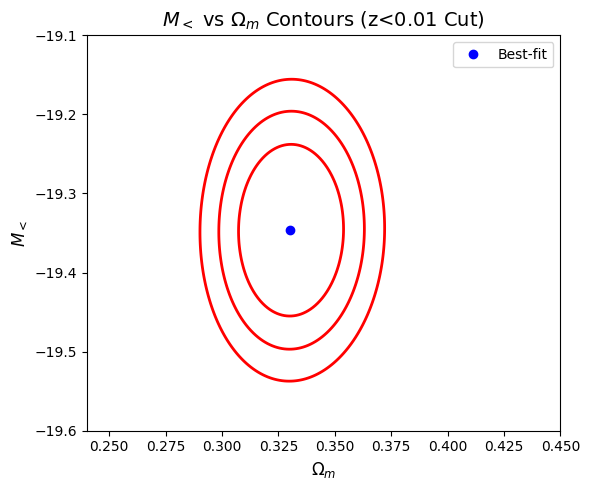

⏱️ Execution time: 389.98 seconds


In [8]:
start_time = time.time()

@lru_cache(maxsize=None)
def integral_dL(z, H0, Omega_m):
    integrand = lambda zp: 1 / np.sqrt(Omega_m * (1 + zp)**3 + (1 - Omega_m))
    integral, _ = quad(integrand, 0, z)
    return (1 + z) * c_km_s * integral / H0

def mu_theory(z_array, H0, Omega_m):
    return np.array([
        5 * np.log10(integral_dL(float(z), float(H0), float(Omega_m))) + 25
        for z in z_array
    ])


# --- Δχ² thresholds for 2 parameters ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gamma.ppf(p, dof / 2)

levels = [delta_chi2(n, 5) for n in [1, 2, 3]]

# --- Transition chi2 with z < 0.01 cut applied ---
def chi2_transition_zcut(params, z, mB, mu_Ceph, is_calibrator, C_inv, mu_SH0ES=19.253):
    M_low, M_high, H0, Omega_m, mu_crit = params
    Q = []
    for i in range(len(z)):
        if is_calibrator[i] == 0 and z[i] < 0.01:
            Q.append(0.0)
            continue
        mu_model = mu_theory([z[i]], H0, Omega_m)[0]
        mu_i_S = mB[i] + mu_SH0ES
        if is_calibrator[i] == 1:
            Q_i = mB[i] - (M_low if mu_i_S < mu_crit else M_high) - mu_Ceph[i]
        else:
            Q_i = mB[i] - (M_low if mu_i_S < mu_crit else M_high) - mu_model
        Q.append(Q_i)
    Q = np.array(Q)
    return Q @ C_inv @ Q

# --- Grid setup for M< vs Omega ---
Mlow_range = np.linspace(-19.60, -19.10, 200)
Om_range = np.linspace(0.24, 0.45, 200)

# --- Best-fit values from transition model with z < 0.01 cut ---
M_low_best, M_high_best, H0_best, Omega_m_best, d_crit_best = result.x
mu_crit_best = 5 * np.log10(d_crit_best) + 25

# --- Compute chi2 grid ---
chi2_grid = np.array([
    [
        chi2_transition_zcut(
            [M_low, M_high_best, H0_best, Om, mu_crit_best],
            z, mB, mu_Ceph, is_calibrator, C_inv
        )
        for Om in Om_range
    ]
    for M_low in Mlow_range
])

# --- Save grid ---
np.savez("contour_data/contour_data_Mlow_Om_cut.npz",
         Mlow=Mlow_range, Om=Om_range, chi2=chi2_grid,
         M_low_best=M_low_best, Om_best=Omega_m_best)

# --- Plotting ---
chi2_min = np.min(chi2_grid)
dchi2 = chi2_grid - chi2_min_cut

plt.figure(figsize=(6, 5))
plt.contour(Om_range, Mlow_range, dchi2, levels=levels, colors='red', linewidths=2)
plt.plot(Omega_m_best, M_low_best, 'bo', markersize=6, label='Best-fit')

plt.xlabel(r"$\Omega_m$", fontsize=12)
plt.ylabel(r"$M_<$", fontsize=12)
plt.title(r"$M_<$ vs $\Omega_m$ Contours (z<0.01 Cut)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("Mlow_vs_Om_cut.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


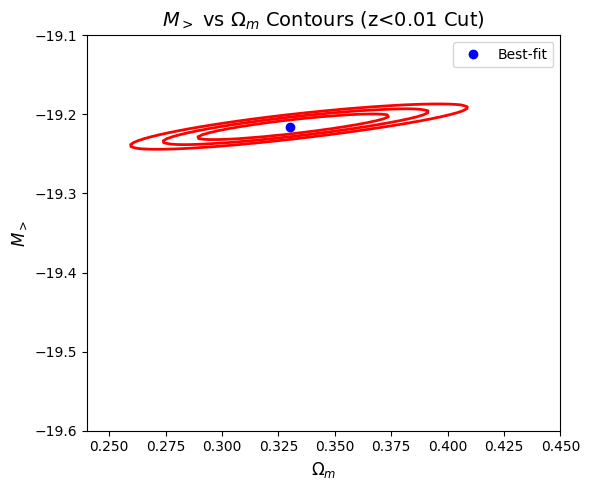

⏱️ Execution time: 364.41 seconds


In [9]:
start_time = time.time()

# --- Grid setup for M> vs Omega ---
Mhigh_range = np.linspace(-19.60, -19.10, 200)
Om_range = np.linspace(0.24, 0.45, 200)

# --- Δχ² thresholds for 2 parameters ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gamma.ppf(p, dof / 2)

levels = [delta_chi2(n, 5) for n in [1, 2, 3]]


# --- Best-fit values (already defined) ---
# M_low_best, M_high_best, H0_best, Omega_m_best, d_crit_best = result.x
mu_crit_best = 5 * np.log10(d_crit_best) + 25

# --- Compute chi2 grid ---
chi2_grid = np.array([
    [
        chi2_transition_zcut(
            [M_low_best, M_high, H0_best, Om, mu_crit_best],
            z, mB, mu_Ceph, is_calibrator, C_inv
        )
        for Om in Om_range
    ]
    for M_high in Mhigh_range
])

# --- Save grid ---
np.savez("contour_data/contour_data_Mhigh_Om_cut.npz",
         Mhigh=Mhigh_range, Om=Om_range, chi2=chi2_grid,
         M_high_best=M_high_best, Om_best=Omega_m_best)

# --- Plotting ---
chi2_min = np.min(chi2_grid)
dchi2 = chi2_grid - chi2_min_cut

plt.figure(figsize=(6, 5))
plt.contour(Om_range, Mhigh_range, dchi2, levels=levels, colors='red', linewidths=2)
plt.plot(Omega_m_best, M_high_best, 'bo', markersize=6, label='Best-fit')

plt.xlabel(r"$\Omega_m$", fontsize=12)
plt.ylabel(r"$M_>$", fontsize=12)
plt.title(r"$M_>$ vs $\Omega_m$ Contours (z<0.01 Cut)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("Mhigh_vs_Om_cut.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


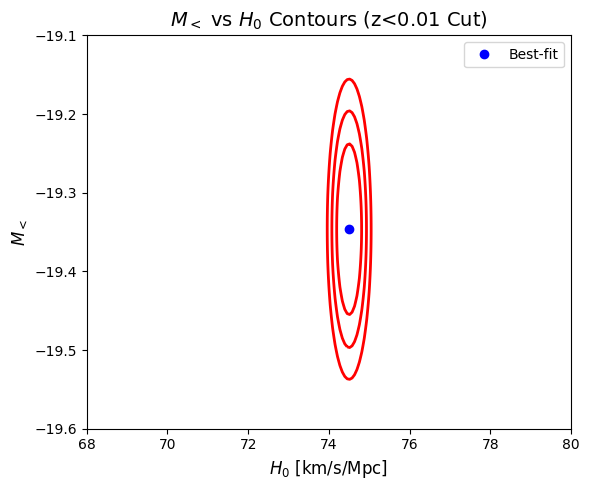

⏱️ Execution time: 411.68 seconds


In [12]:
start_time = time.time()

@lru_cache(maxsize=None)
def integral_dL(z, H0, Omega_m):
    integrand = lambda zp: 1 / np.sqrt(Omega_m * (1 + zp)**3 + (1 - Omega_m))
    integral, _ = quad(integrand, 0, z)
    return (1 + z) * c_km_s * integral / H0

def mu_theory(z_array, H0, Omega_m):
    return np.array([
        5 * np.log10(integral_dL(float(z), float(H0), float(Omega_m))) + 25
        for z in z_array
    ])


# --- Δχ² thresholds for 2 parameters ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gamma.ppf(p, dof / 2)

levels = [delta_chi2(n, 5) for n in [1, 2, 3]]

# --- Transition chi2 with z < 0.01 cut applied ---
def chi2_transition_zcut(params, z, mB, mu_Ceph, is_calibrator, C_inv, mu_SH0ES=19.253):
    M_low, M_high, H0, Omega_m, mu_crit = params
    Q = []
    for i in range(len(z)):
        if is_calibrator[i] == 0 and z[i] < 0.01:
            Q.append(0.0)
            continue
        mu_model = mu_theory([z[i]], H0, Omega_m)[0]
        mu_i_S = mB[i] + mu_SH0ES
        if is_calibrator[i] == 1:
            Q_i = mB[i] - (M_low if mu_i_S < mu_crit else M_high) - mu_Ceph[i]
        else:
            Q_i = mB[i] - (M_low if mu_i_S < mu_crit else M_high) - mu_model
        Q.append(Q_i)
    Q = np.array(Q)
    return Q @ C_inv @ Q
# --- Grid setup for M< vs H0 ---
Mlow_range = np.linspace(-19.60, -19.10, 200)
H0_range = np.linspace(68, 80, 200)

# --- Δχ² thresholds for 2 parameters ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gamma.ppf(p, dof / 2)

levels = [delta_chi2(n, 5) for n in [1, 2, 3]]

# --- Best-fit values (already defined) ---
# M_low_best, M_high_best, H0_best, Omega_m_best, d_crit_best = result.x
mu_crit_best = 5 * np.log10(d_crit_best) + 25

# --- Compute chi2 grid ---
chi2_grid = np.array([
    [
        chi2_transition_zcut(
            [M_low, M_high_best, H0, Omega_m_best, mu_crit_best],
            z, mB, mu_Ceph, is_calibrator, C_inv
        )
        for H0 in H0_range
    ]
    for M_low in Mlow_range
])

# --- Save grid ---
np.savez("contour_data/contour_data_Mlow_H0_cut.npz",
         Mlow=Mlow_range, H0=H0_range, chi2=chi2_grid,
         M_low_best=M_low_best, H0_best=H0_best)

# --- Plotting ---
chi2_min = np.min(chi2_grid)
dchi2 = chi2_grid - chi2_min_cut

plt.figure(figsize=(6, 5))
plt.contour(H0_range, Mlow_range, dchi2, levels=levels, colors='red', linewidths=2)
plt.plot(H0_best, M_low_best, 'bo', markersize=6, label='Best-fit')

plt.xlabel(r"$H_0$ [km/s/Mpc]", fontsize=12)
plt.ylabel(r"$M_<$", fontsize=12)
plt.title(r"$M_<$ vs $H_0$ Contours (z<0.01 Cut)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("Mlow_vs_H0_cut.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


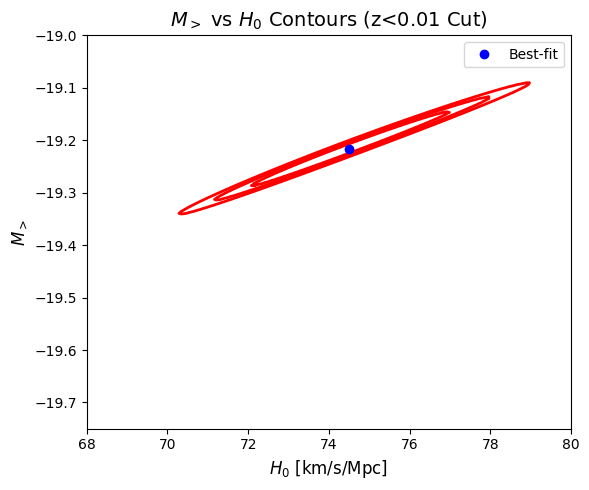

⏱️ Execution time: 371.19 seconds


In [13]:
start_time = time.time()

# --- Grid setup for M> vs H0 ---
Mhigh_range = np.linspace(-19.75, -19.00, 200)
H0_range = np.linspace(68, 80, 200)

# --- Best-fit values (already defined) ---
# M_low_best, M_high_best, H0_best, Omega_m_best, d_crit_best = result.x
mu_crit_best = 5 * np.log10(d_crit_best) + 25
# --- Δχ² thresholds for 2 parameters ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gamma.ppf(p, dof / 2)

levels = [delta_chi2(n, 5) for n in [1, 2, 3]]
# --- Compute chi2 grid ---
chi2_grid = np.array([
    [
        chi2_transition_zcut(
            [M_low_best, M_high, H0, Omega_m_best, mu_crit_best],
            z, mB, mu_Ceph, is_calibrator, C_inv
        )
        for H0 in H0_range
    ]
    for M_high in Mhigh_range
])

# --- Save grid ---
np.savez("contour_data/contour_data_Mhigh_H0_cut.npz",
         Mhigh=Mhigh_range, H0=H0_range, chi2=chi2_grid,
         M_high_best=M_high_best, H0_best=H0_best)

# --- Plotting ---
chi2_min = np.min(chi2_grid)
dchi2 = chi2_grid - chi2_min_cut

plt.figure(figsize=(6, 5))
plt.contour(H0_range, Mhigh_range, dchi2, levels=levels, colors='red', linewidths=2)
plt.plot(H0_best, M_high_best, 'bo', markersize=6, label='Best-fit')

plt.xlabel(r"$H_0$ [km/s/Mpc]", fontsize=12)
plt.ylabel(r"$M_>$", fontsize=12)
plt.title(r"$M_>$ vs $H_0$ Contours (z<0.01 Cut)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("Mhigh_vs_H0_cut.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


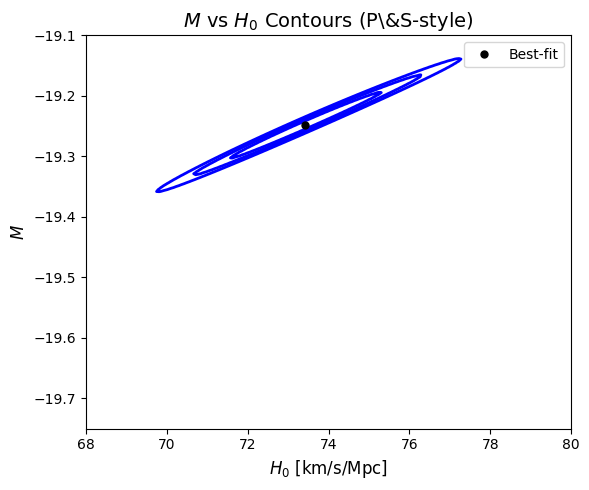

⏱️ Execution time: 201.89 seconds


In [14]:
start_time = time.time()

# --- Cosmology + Distance ---
@lru_cache(maxsize=None)
def integral_dL(z, H0, Omega_m):
    integrand = lambda zp: 1 / np.sqrt(Omega_m * (1 + zp)**3 + (1 - Omega_m))
    integral, _ = quad(integrand, 0, z)
    return (1 + z) * c_km_s * integral / H0

def mu_theory(z_array, H0, Omega_m):
    return np.array([
        5 * np.log10(integral_dL(float(z), float(H0), float(Omega_m))) + 25
        for z in z_array
    ])

# --- Chi2 for no-transition model ---
def chi2_notransition(params, z, mB, mu_Ceph, is_calibrator, C_inv):
    M, H0, Omega_m = params
    mu_model = mu_theory(z, H0, Omega_m)
    Q = np.where(
        is_calibrator == 1,
        mB - M - mu_Ceph,
        mB - M - mu_model
    )
    return Q.T @ C_inv @ Q

# --- Gamma-based Δχ² thresholds (dof = 3) ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gamma.ppf(p, dof / 2)

levels = [delta_chi2(n, 3) for n in [1, 2, 3]]

# --- Grid setup for M vs H0 ---
M_range = np.linspace(-19.75, -19.10, 200)
H0_range = np.linspace(68, 80, 200)

# --- Load best-fit values from no-transition minimization ---
M_best = M_best_notransition
H0_best = H0_best_notransition
Omega_m_best = Omega_m_best_notransition

# --- Compute chi2 grid ---
chi2_grid = np.array([
    [
        chi2_notransition([M, H0, Omega_m_best], z, mB, mu_Ceph, is_calibrator, C_inv)
        for H0 in H0_range
    ]
    for M in M_range
])

# --- Save data ---
os.makedirs("contour_data", exist_ok=True)
np.savez("contour_data/contour_data_M_H0.npz",
         M=M_range, H0=H0_range, chi2=chi2_grid,
         M_best=M_best, H0_best=H0_best)

# --- Plotting ---
chi2_min = chi2_notransition([M_best, H0_best, Omega_m_best], z, mB, mu_Ceph, is_calibrator, C_inv)
dchi2 = chi2_grid - chi2_min

plt.figure(figsize=(6, 5))
CS = plt.contour(H0_range, M_range, dchi2, levels=levels, colors='blue', linewidths=2)
plt.plot(H0_best, M_best, 'ko', label='Best-fit', markersize=5)

plt.xlabel(r"$H_0$ [km/s/Mpc]", fontsize=12)
plt.ylabel(r"$M$", fontsize=12)
plt.title(r"$M$ vs $H_0$ Contours (P\&S-style)", fontsize=14)

# (NO σ LABELS)
plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("M_vs_H0_PandS_style.pdf", dpi=300)
plt.show()

end_time = time.time()
print(f"⏱️ Execution time: {end_time - start_time:.2f} seconds")


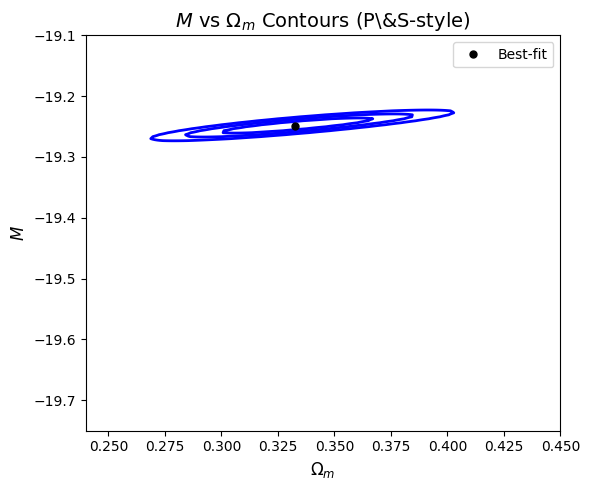

In [15]:
# --- Grid setup for M vs Omega ---
M_range = np.linspace(-19.75, -19.10, 200)
Om_range = np.linspace(0.24, 0.45, 200)

# --- Best-fit values (from no-transition minimization) ---
M_best = M_best_notransition
H0_best = H0_best_notransition
Omega_m_best = Omega_m_best_notransition

# --- Compute chi2 grid ---
chi2_grid = np.array([
    [
        chi2_notransition([M, H0_best, Om], z, mB, mu_Ceph, is_calibrator, C_inv)
        for Om in Om_range
    ]
    for M in M_range
])

# --- Save output ---
os.makedirs("contour_data", exist_ok=True)
np.savez("contour_data/contour_data_M_Om.npz",
         M=M_range, Om=Om_range, chi2=chi2_grid,
         M_best=M_best, Om_best=Omega_m_best)

# --- Plotting ---
chi2_min = chi2_notransition([M_best, H0_best, Omega_m_best], z, mB, mu_Ceph, is_calibrator, C_inv)
dchi2 = chi2_grid - chi2_min

plt.figure(figsize=(6, 5))
CS = plt.contour(Om_range, M_range, dchi2, levels=levels, colors='blue', linewidths=2)
plt.plot(Omega_m_best, M_best, 'ko', label='Best-fit', markersize=5)

plt.xlabel(r"$\Omega_m$", fontsize=12)
plt.ylabel(r"$M$", fontsize=12)
plt.title(r"$M$ vs $\Omega_m$ Contours (P\&S-style)", fontsize=14)

plt.grid(False)
plt.tight_layout()
plt.legend()
plt.savefig("M_vs_Om_PandS_style.pdf", dpi=300)
plt.show()

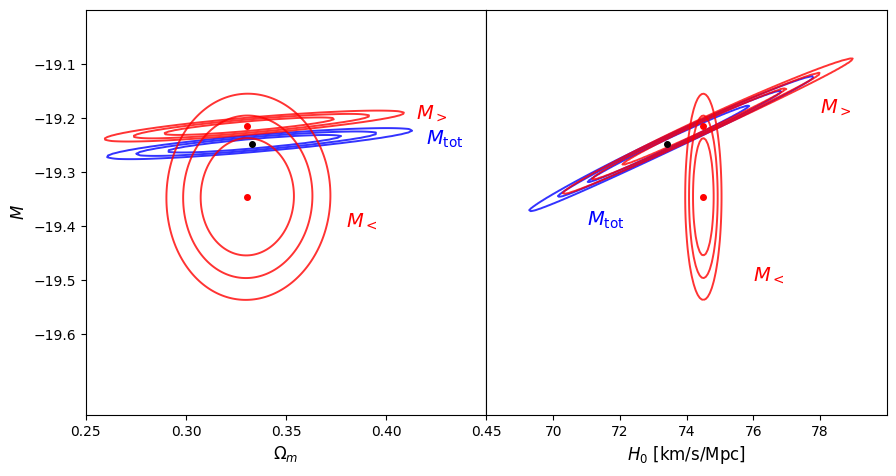

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf, gammaincinv
import matplotlib.gridspec as gridspec

# --- Load no-transition model from full dataset (no cut) ---
data_M_H0 = np.load("contour_data/contour_data_M_H0.npz")
data_M_Om = np.load("contour_data/contour_data_M_Om.npz")

# --- Load transition model with z<0.01 cut ---
data_Mlow_H0 = np.load("contour_data/contour_data_Mlow_H0_cut.npz")
data_Mhigh_H0 = np.load("contour_data/contour_data_Mhigh_H0_cut.npz")
data_Mlow_Om = np.load("contour_data/contour_data_Mlow_Om_cut.npz")
data_Mhigh_Om = np.load("contour_data/contour_data_Mhigh_Om_cut.npz")

# --- Extract parameter ranges ---
H0_range = data_M_H0["H0"]
Om_range = data_M_Om["Om"]
M_range = data_M_H0["M"]

Mlow_range_H0 = data_Mlow_H0["Mlow"]
Mhigh_range_H0 = data_Mhigh_H0["Mhigh"]
Mlow_range_Om = data_Mlow_Om["Mlow"]
Mhigh_range_Om = data_Mhigh_Om["Mhigh"]
Om_range_low = data_Mlow_Om["Om"]
Om_range_high = data_Mhigh_Om["Om"]

# --- Extract chi2 grids and normalize ---
dchi2_MH0 = data_M_H0["chi2"] - np.min(data_M_H0["chi2"])
dchi2_MOm = data_M_Om["chi2"] - np.min(data_M_Om["chi2"])
dchi2_Mlow_H0 = data_Mlow_H0["chi2"] - np.min(data_Mlow_H0["chi2"])
dchi2_Mhigh_H0 = data_Mhigh_H0["chi2"] - np.min(data_Mhigh_H0["chi2"])
dchi2_Mlow_Om = data_Mlow_Om["chi2"] - np.min(data_Mlow_Om["chi2"])
dchi2_Mhigh_Om = data_Mhigh_Om["chi2"] - np.min(data_Mhigh_Om["chi2"])

# --- Best-fit values ---
H0_best = data_M_H0["H0_best"]
M_best = data_M_H0["M_best"]
Om_best = data_M_Om["Om_best"]

M_low_best = data_Mlow_H0["M_low_best"]
M_high_best = data_Mhigh_H0["M_high_best"]
H0_best_tr = data_Mlow_H0["H0_best"]
Om_best_tr = data_Mlow_Om["Om_best"]

# --- Confidence levels (Gamma-based) ---
def delta_chi2(n_sigma, dof):
    alpha = 1 - erf(n_sigma / np.sqrt(2))
    p = 1 - alpha
    return 2 * gammaincinv(dof / 2, p)

levels = [delta_chi2(n, 5) for n in [1, 2, 3]]

# --- Plot layout ---
fig = plt.figure(figsize=(9, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
gs.update(wspace=0.0)

# --- LEFT: M vs Omega ---
ax1 = plt.subplot(gs[0])
ax1.contour(Om_range, M_range, dchi2_MOm, levels=levels, colors='blue', linewidths=1.4, alpha=0.8)
ax1.contour(Om_range_low, Mlow_range_Om, dchi2_Mlow_Om, levels=levels, colors='red', linewidths=1.4, alpha=0.8)
ax1.contour(Om_range_high, Mhigh_range_Om, dchi2_Mhigh_Om, levels=levels, colors='red', linewidths=1.4, alpha=0.8)

ax1.plot(Om_best, M_best, 'ko', markersize=4)
ax1.plot(Om_best_tr, M_low_best, 'ro', markersize=4)
ax1.plot(Om_best_tr, M_high_best, 'ro', markersize=4)
ax1.text(0.38, -19.40, r"$M_{<}$", color='red', fontsize=14)
ax1.text(0.415, -19.20, r"$M_{>}$", color='red', fontsize=14)
ax1.text(0.42, -19.25, r"$M_{\mathrm{tot}}$", color='blue', fontsize=14)
ax1.set_xlabel(r"$\Omega_m$", fontsize=12)
ax1.set_ylabel(r"$M$", fontsize=12)
ax1.set_xlim(0.25, 0.45)
ax1.set_ylim(-19.75, -19.00)
ax1.set_xticks([0.25, 0.30, 0.35, 0.40, 0.45])
ax1.set_yticks(np.linspace(-19.6, -19.1, 6))
ax1.tick_params(axis='both', labelsize=10)

# --- RIGHT: M vs H0 ---
ax2 = plt.subplot(gs[1], sharey=ax1)
ax2.contour(H0_range, M_range, dchi2_MH0, levels=levels, colors='blue', linewidths=1.4, alpha=0.8)
ax2.contour(H0_range, Mlow_range_H0, dchi2_Mlow_H0, levels=levels, colors='red', linewidths=1.4, alpha=0.8)
ax2.contour(H0_range, Mhigh_range_H0, dchi2_Mhigh_H0, levels=levels, colors='red', linewidths=1.4, alpha=0.8)

ax2.plot(H0_best, M_best, 'ko', markersize=4)
ax2.plot(H0_best_tr, M_low_best, 'ro', markersize=4)
ax2.plot(H0_best_tr, M_high_best, 'ro', markersize=4)
ax2.text(78, -19.19, r"$M_{>}$", color='red', fontsize=14)
ax2.text(76, -19.50, r"$M_{<}$", color='red', fontsize=14)
ax2.text(71.0, -19.40, r"$M_{\mathrm{tot}}$", color='blue', fontsize=14)
ax2.set_xlabel(r"$H_0$ [km/s/Mpc]", fontsize=12)
ax2.set_xlim(H0_range.min(), H0_range.max())
ax2.set_xticks([70, 72, 74, 76, 78])
ax2.tick_params(axis='y', labelleft=False, left=False)

# --- Save and show ---
plt.subplots_adjust(left=0.08, right=0.97, bottom=0.12, top=0.93)
plt.savefig("Figure2.png", dpi=300)
plt.show()
